In [1]:
import string
import numpy as np
!pip install nltk
!pip install sentence_transformers
!pip install tf-keras
import nltk
import tf_keras
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sentence_transformers import SentenceTransformer
#Модель для преобразования документов в эмбеддинги
model = SentenceTransformer('all-MiniLM-L6-v2')
#Функция базовой предобработки текста
def text_processing(text):
    #Приведение к нижнему регистру
    text = text.lower()
    #Удаление пунктуации
    text = text.translate(str.maketrans('', '', string.punctuation))
    #Токенизация
    tokens = word_tokenize(text)
    #Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    #Лемматизация
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    #Стемминг
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens
    

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vadim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vadim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Vadim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Vadim\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
C:\Users\Vadim\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.4

In [2]:
import os
import numpy as np
folder_path = "sampled_texts"
embeddings = []
#Преобразование текстов в эмбеддинги
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        processed_content = text_processing(content)
        embedding = model.encode(' '.join(processed_content))
        embeddings.append(embedding)
embeddings = np.array(embeddings)

C:\Users\Vadim\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


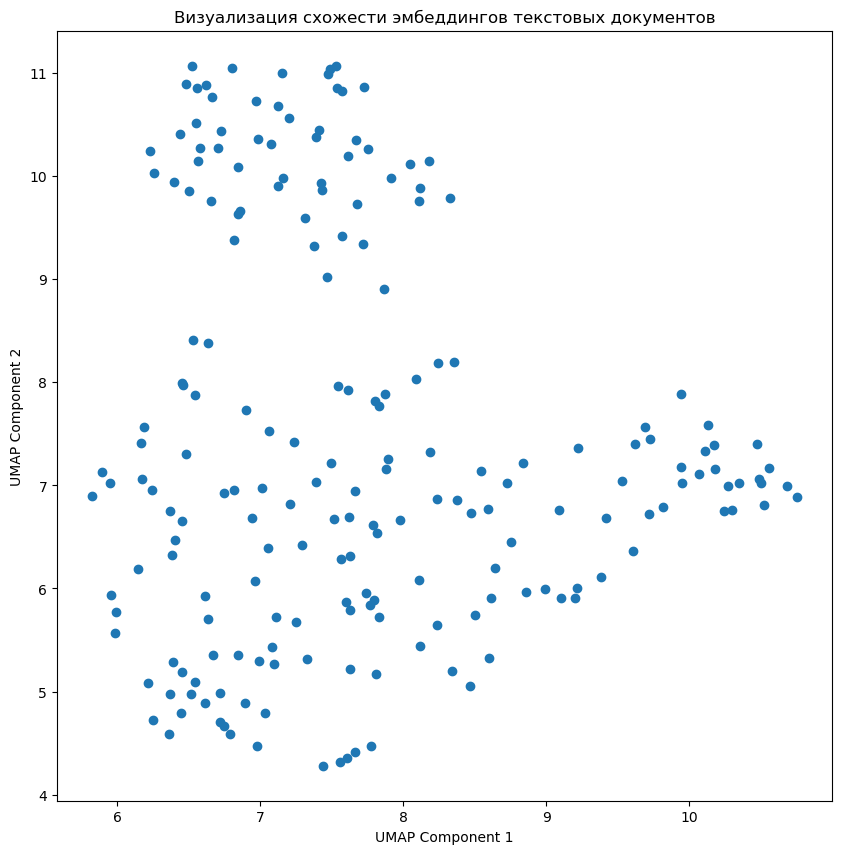

In [3]:
import umap
import matplotlib.pyplot as plt
#Применение UMAP для понижения размерности эмбеддингов
reducer = umap.UMAP(metric = "cosine",random_state =42)
low_dim_embeddings = reducer.fit_transform(embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(low_dim_embeddings[:, 0], low_dim_embeddings[:, 1], marker='o')
plt.title("Визуализация схожести эмбеддингов текстовых документов")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

Для того, чтобы определить оптимальное число кластеров, воспользуемся методом локтя. На графике зависимости инерции(сумма квадратов расстояний всех точек выборки до центроидов ближайших к ним кластеров) от количества кластеров выберем то значение n - количество кластеров, после которого добавление новых кластеров уже не приводит к значительному снижению инерции

C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

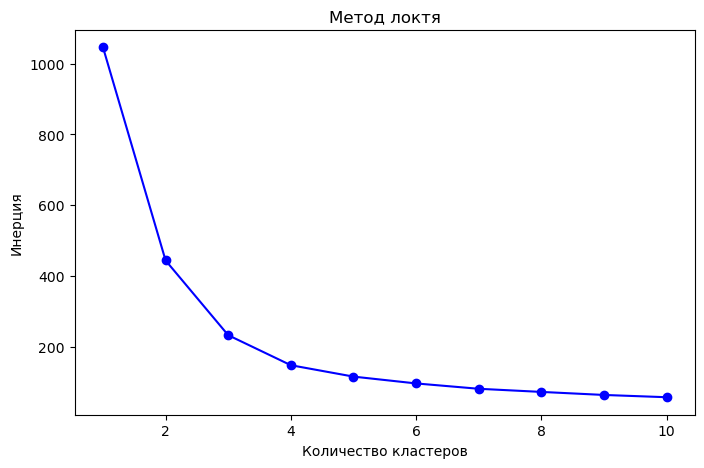

In [4]:
from sklearn.cluster import KMeans
def plot_elbow_method(X, max_k):
    inertias = []
    K = range(1, max_k + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertias, 'bo-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Инерция')
    plt.title('Метод локтя')
    plt.show()
plot_elbow_method(low_dim_embeddings, max_k=10)

Также полезной метрикой в задаче кластеризации является silhouette_score. Она показывает насколько хорошо объекты внутри одного кластера схожи между собой по сравнению с объектами из других кластеров.

C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

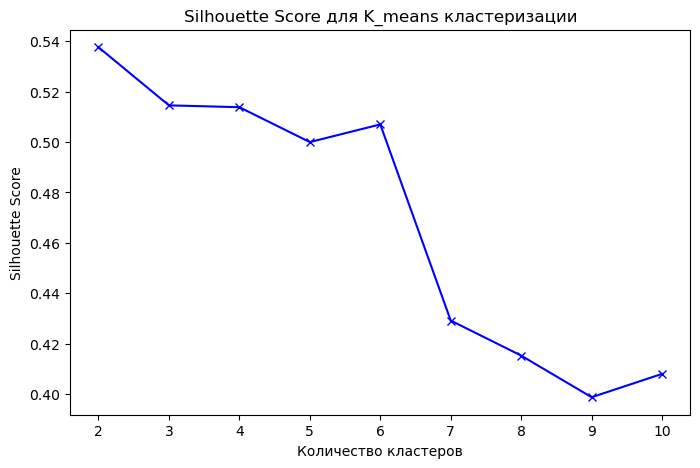

In [5]:
from sklearn.metrics import silhouette_score
def calculate_silhouette_scores(X, max_k):
    scores = []
    K = range(2, max_k + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)
    # Построение графика Silhouette Score
    plt.figure(figsize=(8, 5))
    plt.plot(K, scores, 'bx-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score для K_means кластеризации')
    plt.show()

# Вызов функции
calculate_silhouette_scores(low_dim_embeddings, max_k=10)


Можно сказать, что n - оптимальное количество кластеров = 3, т.к. по графику локтя, после этого значения добавление новых кластеров уже не приводит к значительному снижению инерции, а также при n = 3 количестве кластеров значение silhouette_score является близким к максимальному

In [6]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(low_dim_embeddings)

#Функция для вывода графика кластеризации
def represent_information(new_embedding=None,closest_cluster_index = None):
    colors = ['red', 'blue', 'green']
    plt.figure(figsize=(10, 10))
    for i in range(n_clusters):
        points = low_dim_embeddings[labels == i]
        plt.scatter(points[:, 0], points[:, 1], s=100, c=colors[i], label=f'Кластер {i+1}')
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='purple', marker='X', label='Центроиды')
    if new_embedding is not None:
        plt.scatter(new_embedding[:,0],new_embedding[:,1], s=300, c=colors[closest_cluster_index], marker='*', label='Новый документ')
    plt.title('K_Means кластеризация текстовых документов')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.legend()
    plt.show()

C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Vadim\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


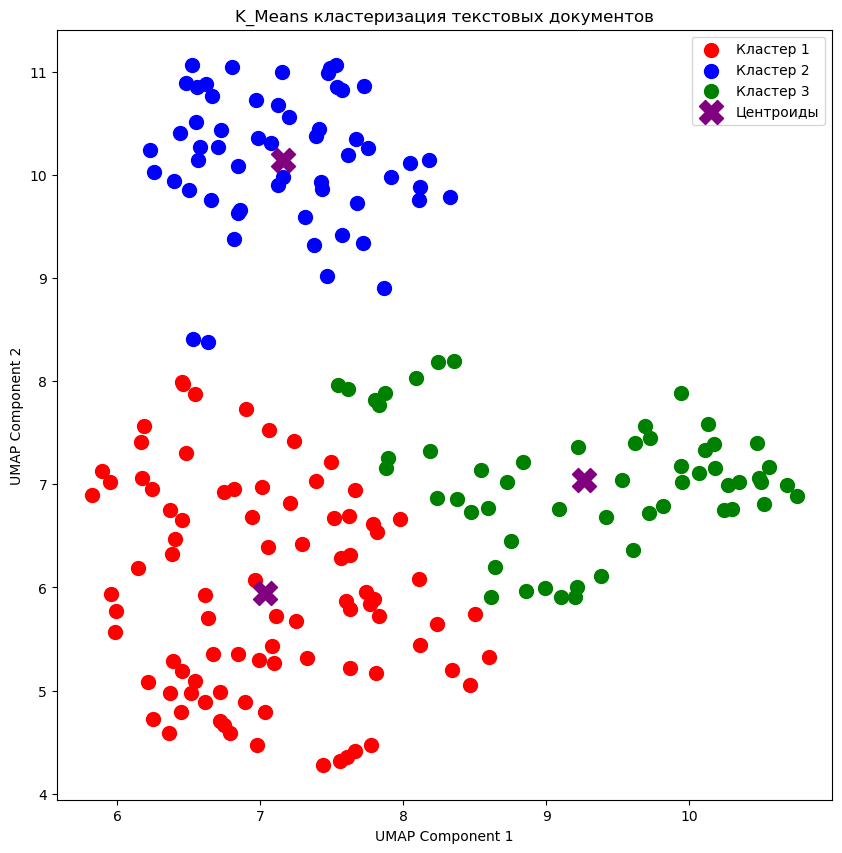

In [7]:
represent_information()

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
#Функция для класификации новых документов и вывода графика кластеризации с новым документом
def new_document(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        processed_content = text_processing(content)
        embedding = model.encode(' '.join(processed_content))
    embedding = np.array(embedding).reshape(1, -1)
    new_embedding = reducer.transform(embedding)
    kmeans_centers = kmeans.cluster_centers_
    #С помощью косинусного сходства определим насколько близок новый документ к существующим кластерам
    similarities = cosine_similarity(new_embedding, kmeans_centers)
    closest_cluster_index = np.argmax(similarities)
    represent_information(new_embedding = new_embedding,closest_cluster_index=closest_cluster_index)
    print(f'Новый документ относится к кластеру {closest_cluster_index + 1}')
    

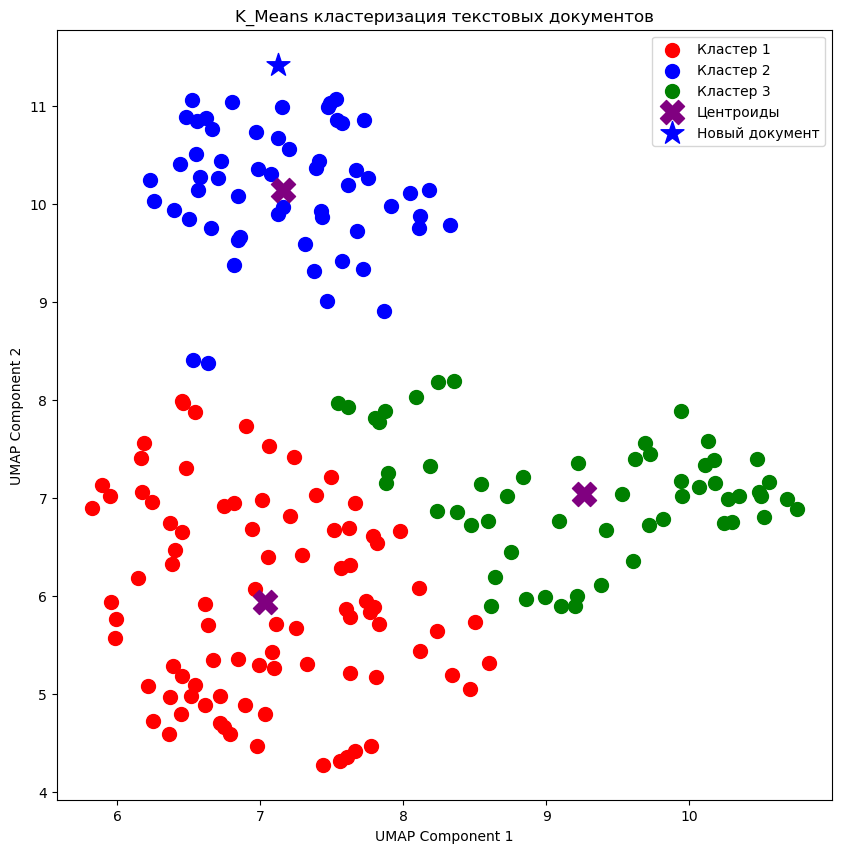

Новый документ относится к кластеру 2


In [9]:
new_document("new_text.txt")